Files found in the outer zip archive: ['bank.zip', 'bank-additional.zip']
Found nested zip: bank.zip. Attempting to open it.
Files found in nested zip 'bank.zip': ['bank-full.csv', 'bank-names.txt', 'bank.csv']
Attempting to open 'bank-full.csv' from nested zip 'bank.zip'.
0.9006856890068569
0.8935087913303107
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      7952
           1       0.59      0.40      0.48      1091

    accuracy                           0.89      9043
   macro avg       0.75      0.68      0.71      9043
weighted avg       0.88      0.89      0.88      9043



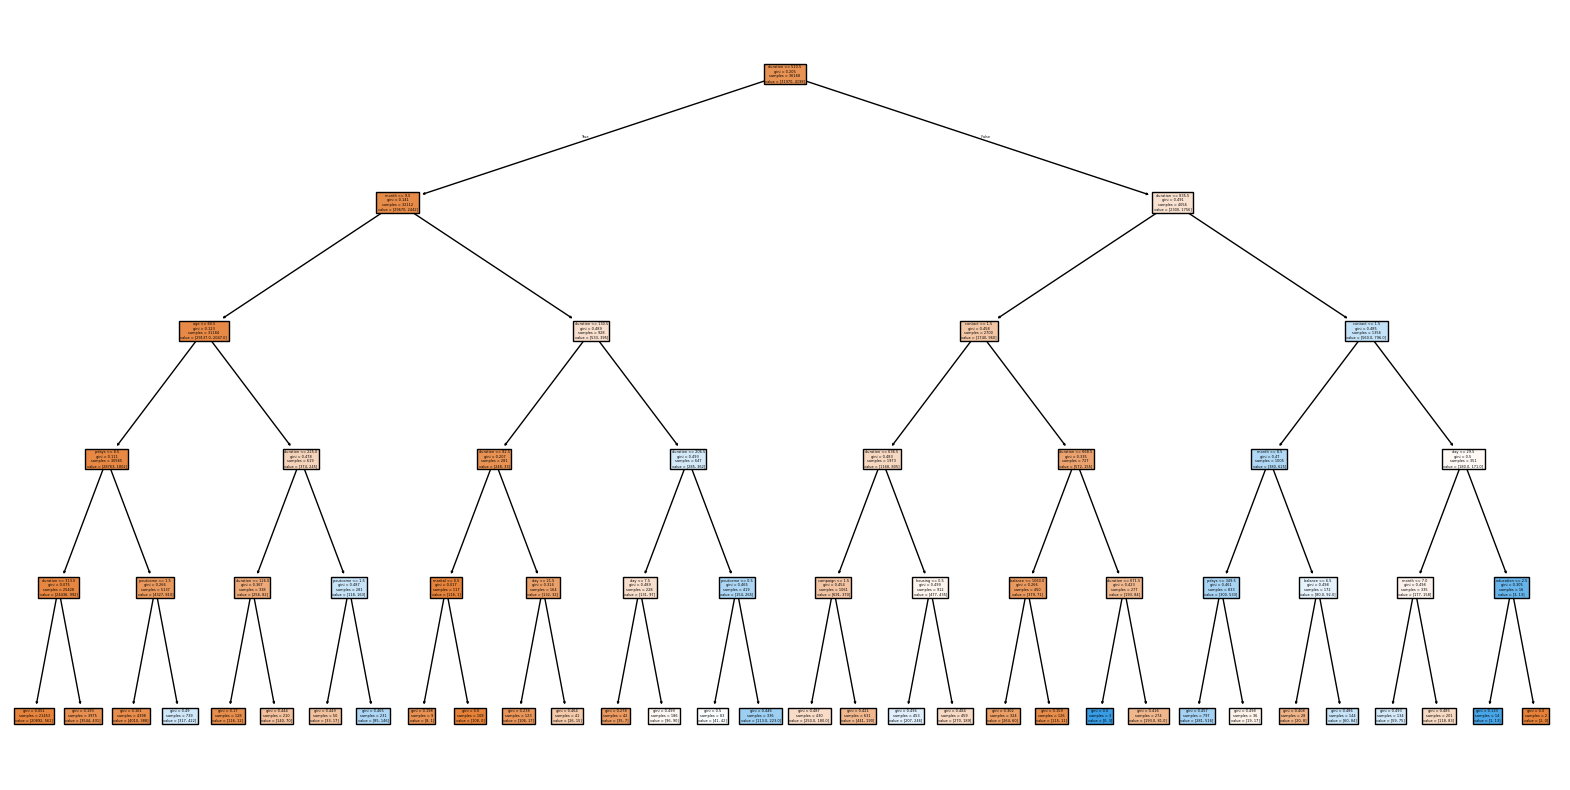

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import requests # New import to handle HTTP requests
import zipfile # New import to handle zip files
import io # New import for in-memory file operations

# The original URL was not working (404 Not Found).
# We will now download the zip file and extract the CSV.
zip_url = "https://archive.ics.uci.edu/static/public/222/bank+marketing.zip"

try:
    # Download the zip file
    response = requests.get(zip_url)
    response.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)

    # Read the zip file content from memory
    with zipfile.ZipFile(io.BytesIO(response.content)) as z_outer:
        file_list_outer = z_outer.namelist()
        print(f"Files found in the outer zip archive: {file_list_outer}")

        data = None

        # First, try to find a CSV directly in the outer zip
        for f_name in file_list_outer:
            if f_name.endswith('.csv'):
                print(f"Attempting to open '{f_name}' from the outer zip archive.")
                with z_outer.open(f_name) as f:
                    data = pd.read_csv(f, sep=";")
                break

        # If no CSV found in the outer zip, check for nested zip files
        if data is None:
            for outer_f_name in file_list_outer:
                if outer_f_name.endswith('.zip'):
                    print(f"Found nested zip: {outer_f_name}. Attempting to open it.")
                    try:
                        with z_outer.open(outer_f_name) as nested_zip_data:
                            with zipfile.ZipFile(io.BytesIO(nested_zip_data.read())) as z_inner:
                                file_list_inner = z_inner.namelist()
                                print(f"Files found in nested zip '{outer_f_name}': {file_list_inner}")

                                for inner_f_name in file_list_inner:
                                    # Often 'bank-full.csv' or 'bank.csv' within the nested zips
                                    if inner_f_name.endswith('.csv'):
                                        print(f"Attempting to open '{inner_f_name}' from nested zip '{outer_f_name}'.")
                                        with z_inner.open(inner_f_name) as f:
                                            data = pd.read_csv(f, sep=";")
                                            break # Found CSV, break inner loop
                                if data is not None:
                                    break # Found CSV, break outer loop
                    except Exception as e:
                        print(f"Could not process nested zip {outer_f_name}: {e}")

        if data is None:
            raise KeyError("No CSV file found inside the zip archive or any nested zip files.")

except requests.exceptions.RequestException as e:
    print(f"Error downloading data: {e}")
    raise
except KeyError as e:
    print(f"Error: {e}. Please check the content of the zip file listed above.")
    raise
except Exception as e:
    print(f"An unexpected error occurred while processing the data: {e}")
    raise

for col in data.columns:
    if data[col].dtype == "object":
        data[col] = LabelEncoder().fit_transform(data[col])

X = data.drop("y", axis=1)
y = data["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

plt.figure(figsize=(20,10))
plot_tree(model, feature_names=X.columns, filled=True)
plt.show()